# Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import models, layers, regularizers

In [2]:
import os

# Use an absolute path with a raw string to handle backslashes correctly
directory = os.path.expanduser(r"C:\Users\shaur\OneDrive\Desktop\PlantDiseaseDetection\Dataset")


In [3]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=30

# Data Preprocessing

# Training Image preprocessing

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )

Found 1730 files belonging to 3 classes.


# Validation Image Preprocessing

In [5]:
class_names=dataset.class_names
class_names

['healthy', 'rust', 'scab']

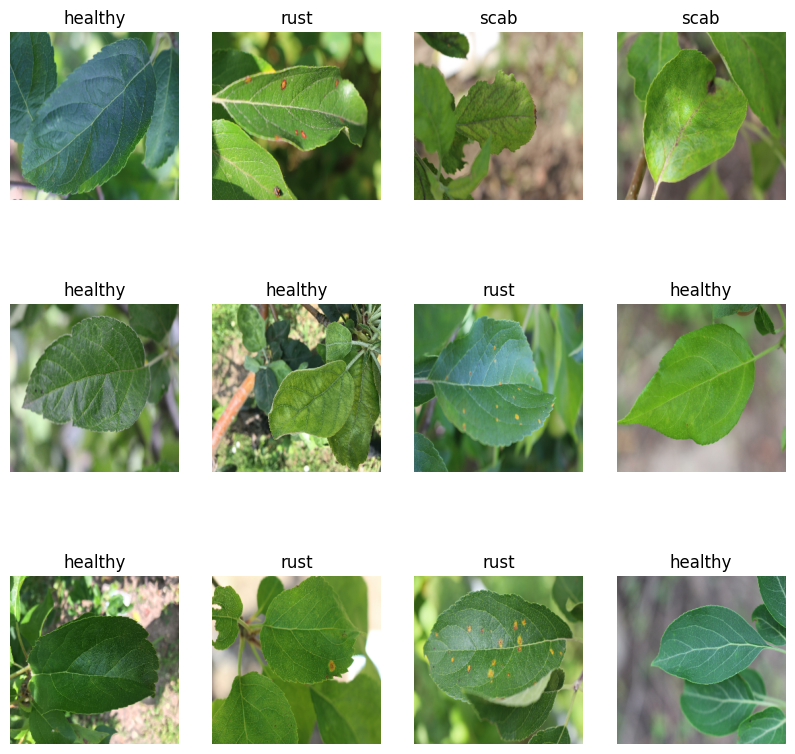

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

55

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

44

In [20]:
len(val_ds)

5

In [21]:
len(test_ds)

6

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [25]:
data_augmentation = tf.keras.Sequential([
   layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
])

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
   
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Lower dropout rate

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
   
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Reduced dropout rate

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Moderate dropout

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
   
    layers.Dropout(0.3),  # Reduced dropout before output

    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

c:\Users\shaur\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.3258 - loss: 1.1238 - val_accuracy: 0.4313 - val_loss: 1.0968
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 908ms/step - accuracy: 0.3950 - loss: 1.0967 - val_accuracy: 0.4875 - val_loss: 1.0824
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 945ms/step - accuracy: 0.3676 - loss: 1.0952 - val_accuracy: 0.4313 - val_loss: 1.0892
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 43s 977ms/step - accuracy: 0.3420 - loss: 1.0858 - val_accuracy: 0.3375 - val_loss: 1.0729
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3992 - loss: 1.0734 - val_accuracy: 0.4187 - val_loss: 1.0646
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 939ms/step - accuracy: 0.4239 - loss: 1.0557 - val_accuracy: 0.5000 - val_loss: 1.0293
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 893ms/step - accuracy: 0.4490 - loss: 1.0340 - val_accuracy: 0.4875 - val_loss: 1.0069
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 909ms/step - accuracy: 0.5205 - loss: 0.9931 - val_accuracy: 

In [30]:
scores=model.evaluate(test_ds)
    

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.9440 - loss: 0.1137


In [31]:
scores

[0.10221534967422485, 0.9635416865348816]

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 44}

In [34]:
type(history.history['loss'])

list

In [35]:
len(history.history['loss'])

30

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

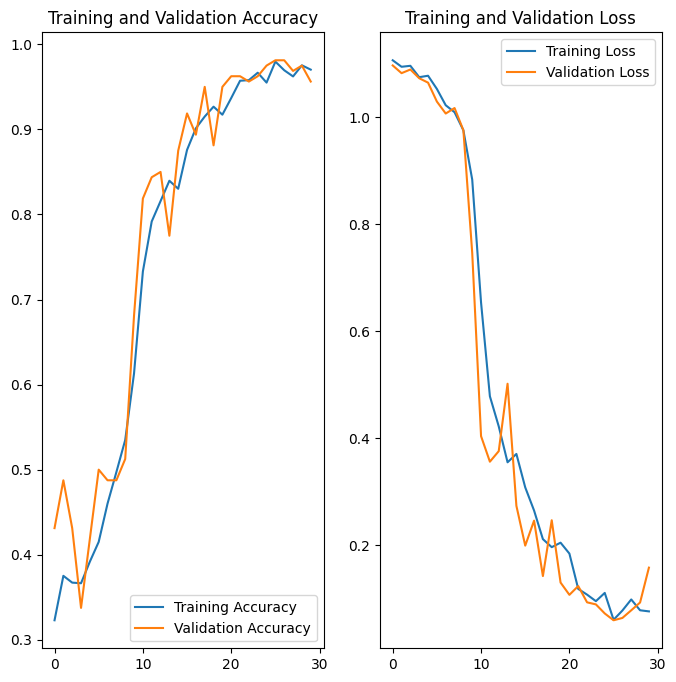

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: scab
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
predicted label: scab


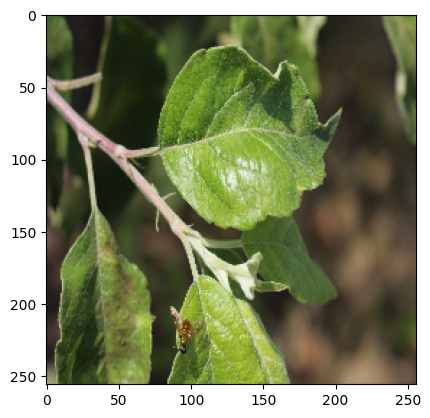

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


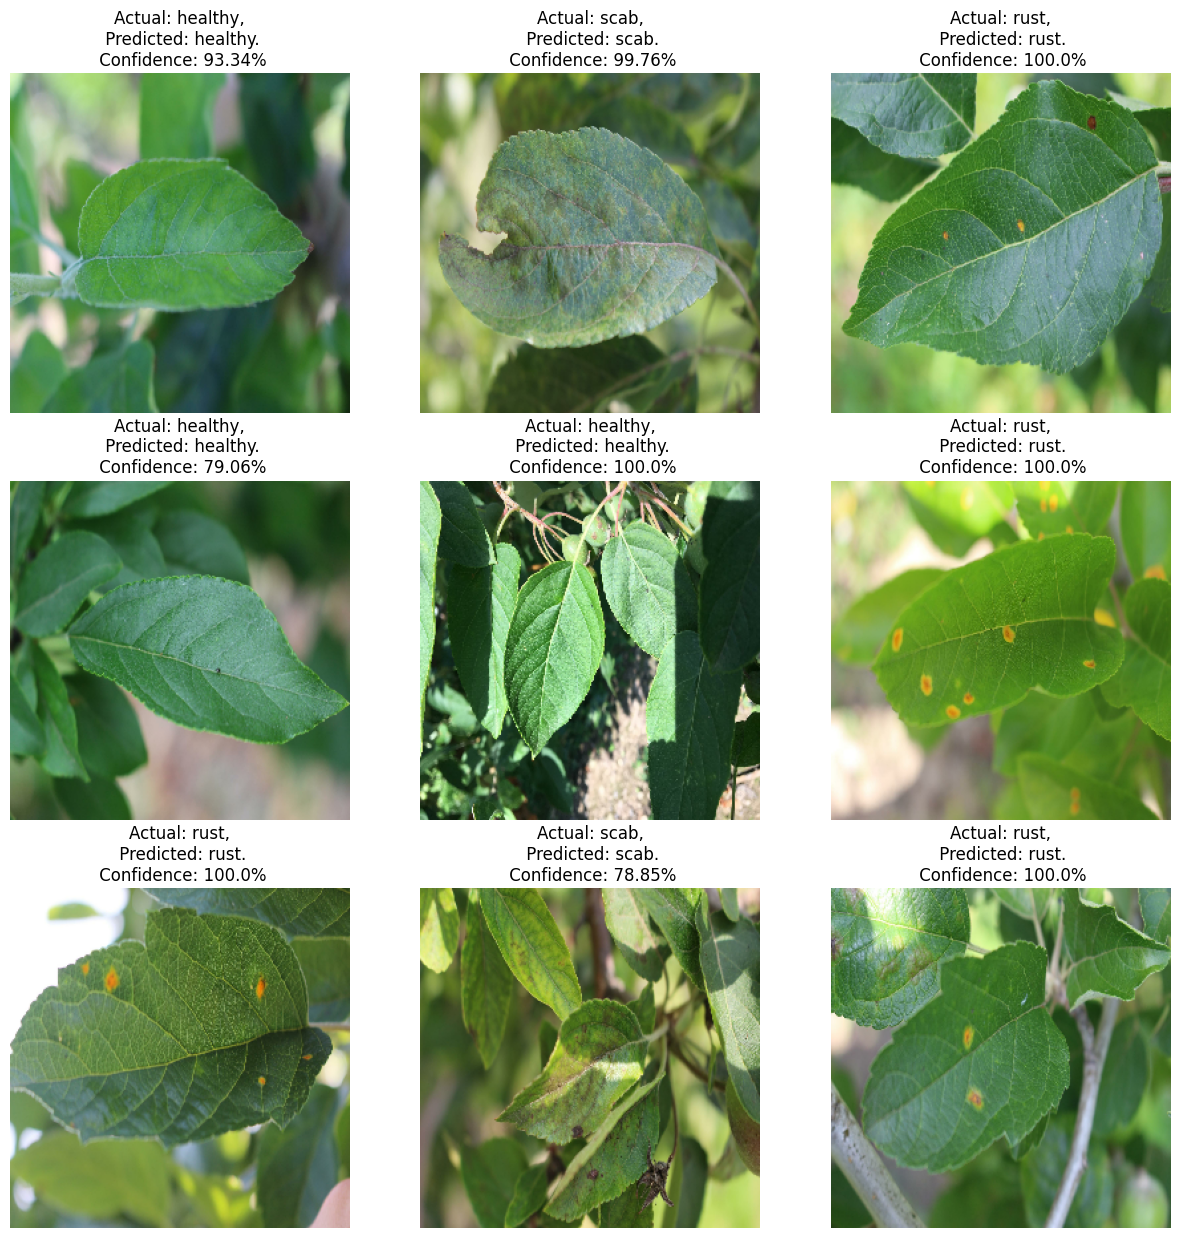

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [43]:
import os
from keras.models import load_model  # If you need to load models later

# Define the directory for saving the model
model_directory = r"C:\Users\shaur\OneDrive\Desktop\PlantDiseaseDetection\models"

# Ensure the directory exists
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Save the model in the native Keras format
model_path = os.path.join(model_directory, "applesNew.keras")

try:
    model.save(model_path)
    print(f"Model saved successfully at: {model_path}")
except Exception as e:
    print(f"An error occurred while saving the model: {e}")

Model saved successfully at: C:\Users\shaur\OneDrive\Desktop\PlantDiseaseDetection\models\applesNew.keras
